# Jet Energy Resolution Plotting

In [1]:
import awkward as ak
import numpy as np
import coffea
import uproot
import hist
import vector
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from distributed.diagnostics.plugin import UploadDirectory
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import pickle
import correctionlib
from coffea.analysis_tools import PackedSelection
from dask.distributed import Client
from scipy.optimize import curve_fit
import csv
import pandas as pd
from python.smp_utils import *

### Plotting the Distribution Widths and their Errors for in $\eta$, $\rho$, and $p_T$ Bins

In [2]:
with open("pkl_files/QCD_pt_response_04-29.pkl", "rb") as f:
    output = pickle.load(f)

histogram_bins = histogram_bin_extractor(output["responses_histogram_rho"])

eras = histogram_bins[0]
dataset_bin_edges, frac_bin_edges, eta_bin_edges, pt_bin_edges, rho_bin_edges = histogram_bins[1]
dataset_bin_centers, frac_bin_centers, eta_bin_centers, pt_bin_centers, rho_bin_centers = histogram_bins[2]
dataset_bin_widths, frac_bin_widths, eta_bin_widths, pt_bin_widths, rho_bin_widths = histogram_bins[3]

pt_bin_centers = pt_bin_centers[0:24]
pt_bin_edges = pt_bin_edges[0:25]

print(f'pT bin centers:\n{pt_bin_centers}\n')
print(f'pT bin edges:\n{pt_bin_edges}\n')
print(f'rho bin edges:\n{rho_bin_edges}\n')
print(f'eta bin edges:\n{eta_bin_edges}\n')

pT bin centers:
[  15.    25.    32.5   37.5   42.5   51.    64.5   81.   105.   135.
  175.   250.   350.   475.   650.   875.  1125.  1375.  1625.  1875.
 2125.  2375.  2625.  2875. ]

pT bin edges:
[  10.   20.   30.   35.   40.   45.   57.   72.   90.  120.  150.  200.
  300.  400.  550.  750. 1000. 1250. 1500. 1750. 2000. 2250. 2500. 2750.
 3000.]

rho bin edges:
[ 0.    7.32 13.2  19.08 24.95 30.83 36.71 90.  ]

eta bin edges:
[0.  0.5 0.8 1.1 1.3 1.7 1.9 2.1 2.3 2.5 2.8 3.  3.2 4.7]



### 2018 - 2016 Datasets

### Barrel measurements

Below we plot the widths of the distributions as functions of $p_T$ in the barrel region $0 < \eta < 1.3$ across all $\rho$ bins, for all years. We start by reading and extracting everything from the csv files produced in `jer_computations.ipynb`. To do so, we will use `read_gaussian_parameters()` which is defined in `smp_utils.py`. Afterwards, we use `extract_sigma_and_err_from_dfs()` to record only the widths and their errors from the distribution fits.

In [3]:
eta_ranges = [(0.0, 0.5), (0.5, 0.8), (0.8, 1.1), (1.1, 1.3)]

rho_ranges = [(0., 7.32), (7.32, 13.2), (13.2, 19.08), (19.08, 24.95), (24.95, 30.83), (30.83, 36.71), (36.71, 90)]

##################### 2018

era_2018 = 2018

pt_bin_lists_2018 = []
sigmas_lists_2018 = []
sigma_errs_lists_2018 = []
filenames_lists_2018 = []
dfs_lists_2018 = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2018, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2018.append(pt_bins)
    sigmas_lists_2018.append(sigmas)
    sigma_errs_lists_2018.append(sigma_errs)
    filenames_lists_2018.append(filenames)
    dfs_lists_2018.append(dfs)
    
##################### 2017

era_2017 = 2017

pt_bin_lists_2017 = []
sigmas_lists_2017 = []
sigma_errs_lists_2017 = []
filenames_lists_2017 = []
dfs_lists_2017 = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2017, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2017.append(pt_bins)
    sigmas_lists_2017.append(sigmas)
    sigma_errs_lists_2017.append(sigma_errs)
    filenames_lists_2017.append(filenames)
    dfs_lists_2017.append(dfs)

##################### 2016APV

era_2016APV = '2016APV'

pt_bin_lists_2016APV = []
sigmas_lists_2016APV = []
sigma_errs_lists_2016APV = []
filenames_lists_2016APV = []
dfs_lists_2016APV = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2016APV, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2016APV.append(pt_bins)
    sigmas_lists_2016APV.append(sigmas)
    sigma_errs_lists_2016APV.append(sigma_errs)
    filenames_lists_2016APV.append(filenames)
    dfs_lists_2016APV.append(dfs)

##################### 2016

era_2016 = 2016

pt_bin_lists_2016 = []
sigmas_lists_2016 = []
sigma_errs_lists_2016 = []
filenames_lists_2016 = []
dfs_lists_2016 = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2016, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2016.append(pt_bins)
    sigmas_lists_2016.append(sigmas)
    sigma_errs_lists_2016.append(sigma_errs)
    filenames_lists_2016.append(filenames)
    dfs_lists_2016.append(dfs)

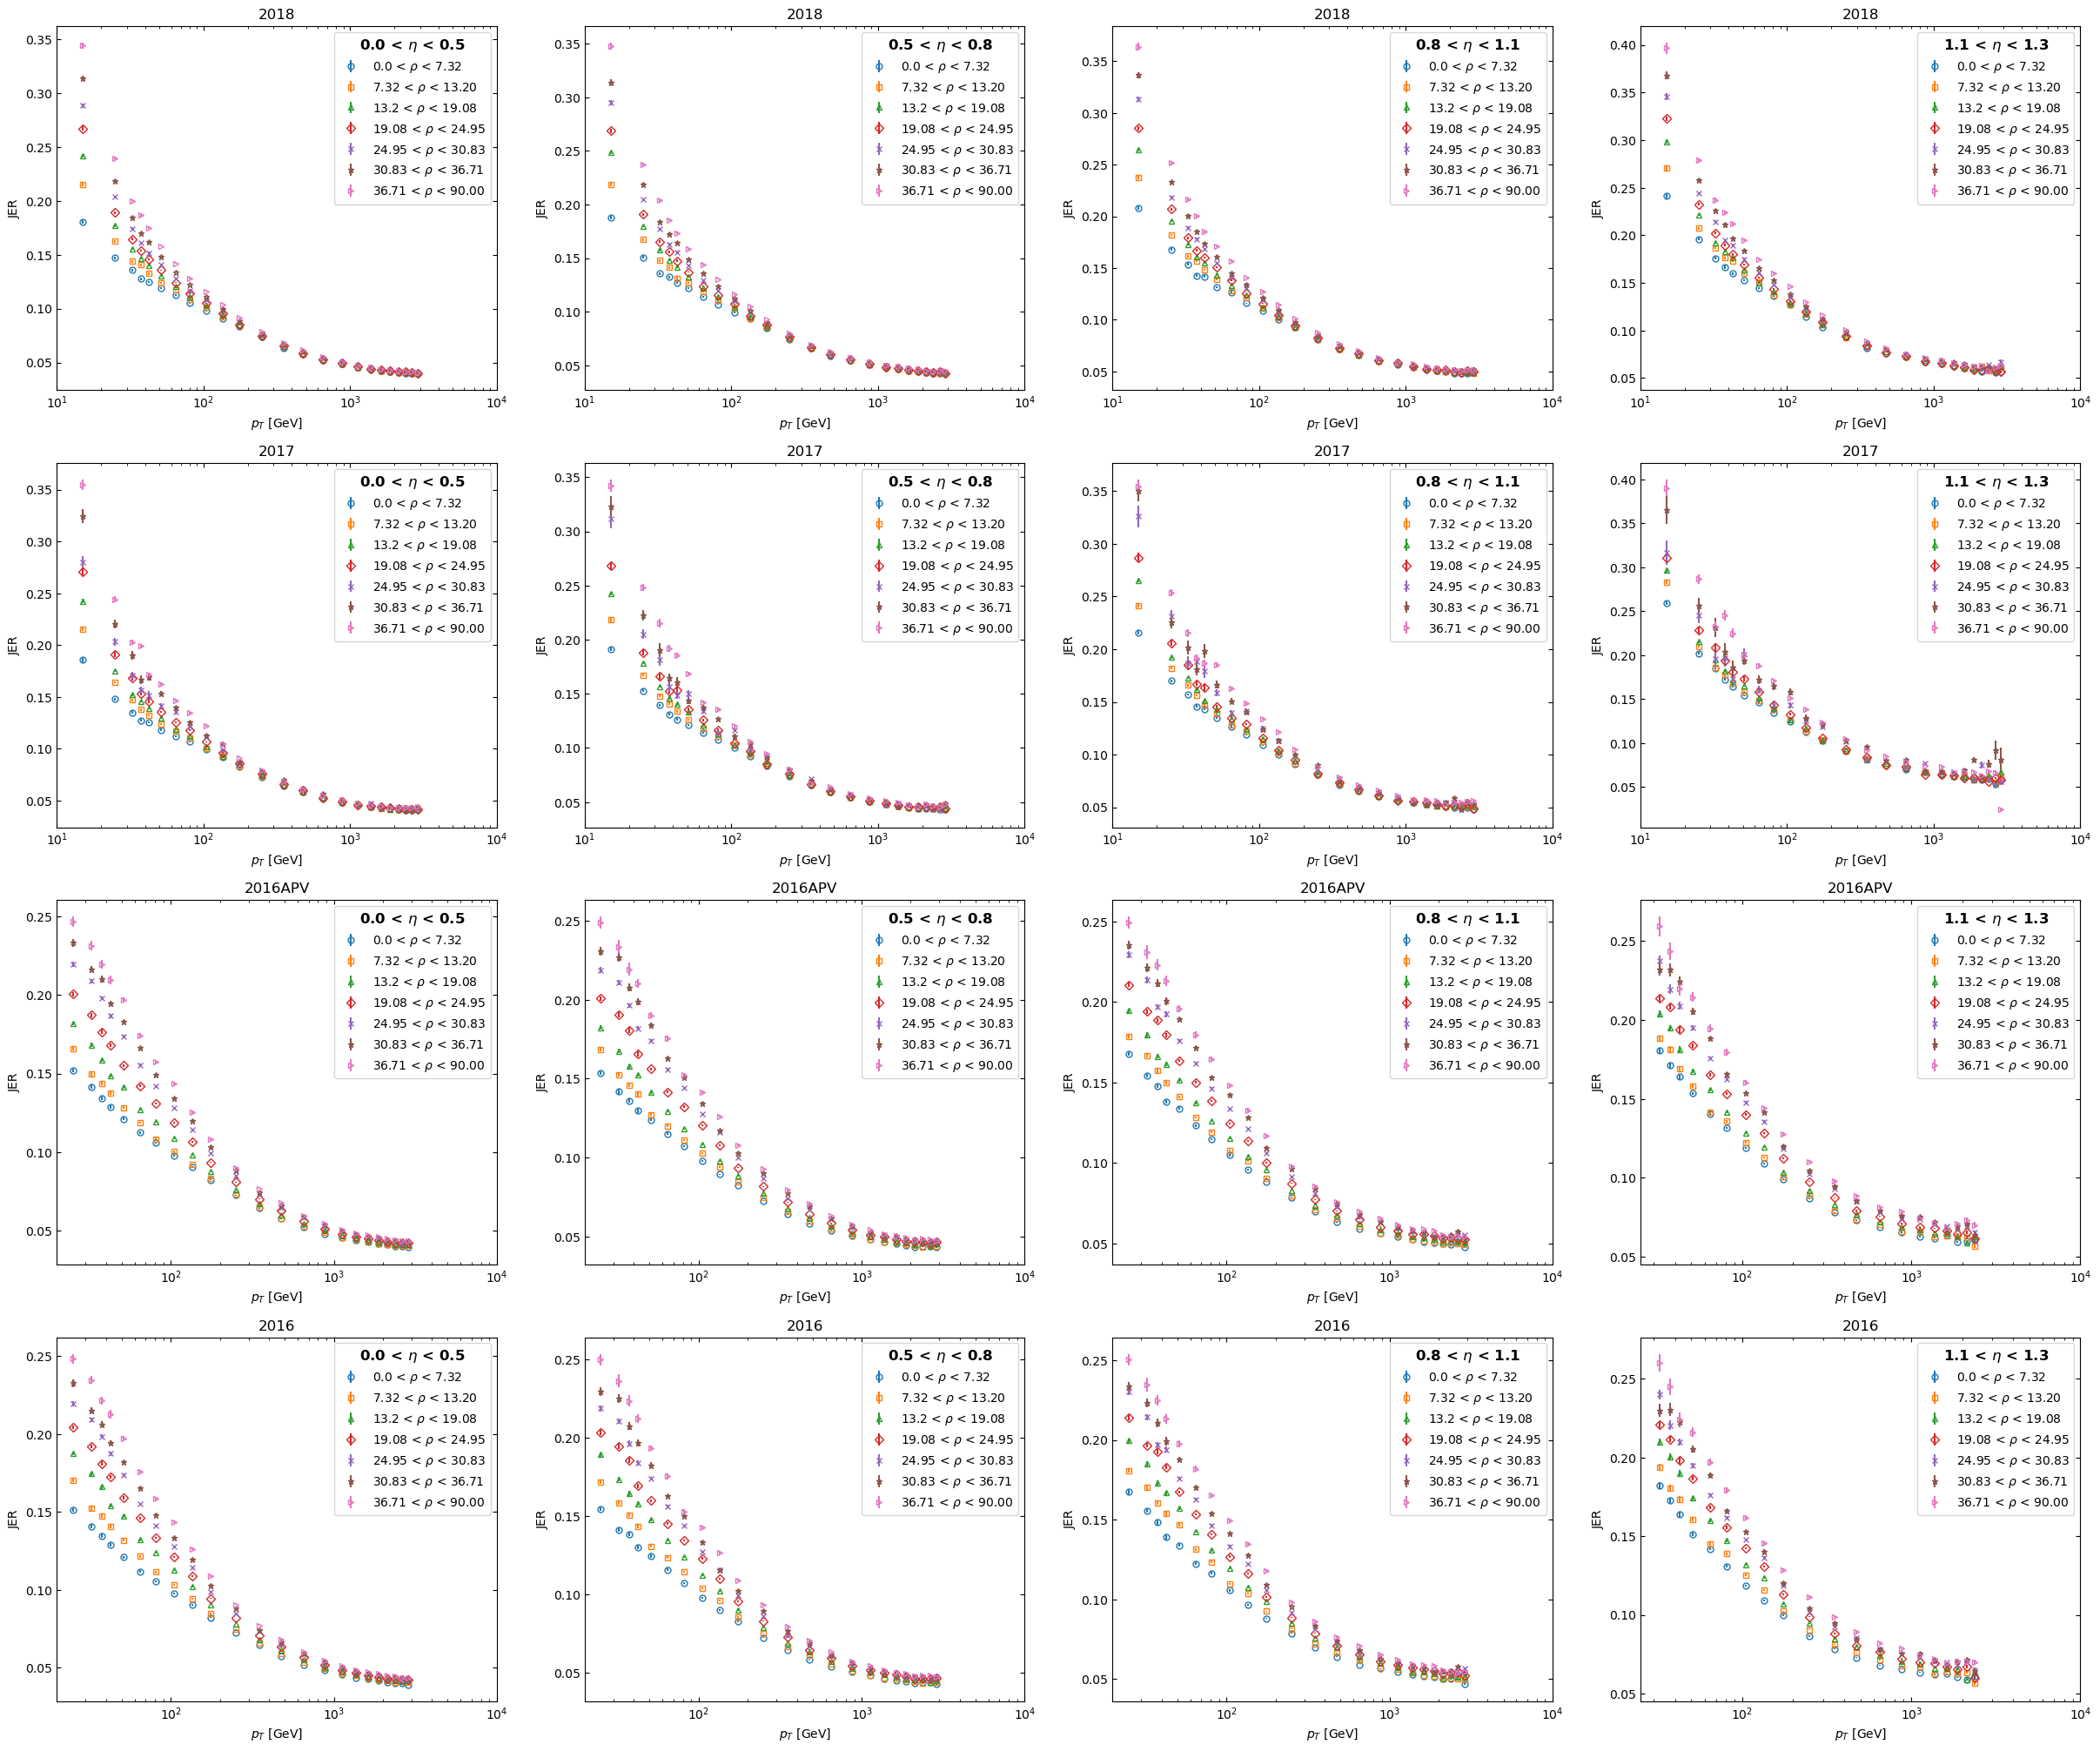

In [4]:
fig, axs = plt.subplots(4, 4, figsize=(30, 25))

markers = ['o', 's', '^', 'D', 'x', '*', '>']
marker_size = 5 

##################### 2018

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2018[0], sigma_errs_lists_2018[0], filenames_lists_2018[0])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[0, 0].errorbar(pt_bin_centers, sigmas, yerr=sigma_errs, fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)     # Use label=filename to verify file 
axs[0, 0].set_title(year)
axs[0, 0].set_xlabel(r"$p_T$ [GeV]")
axs[0, 0].set_ylabel("JER")
axs[0, 0].set_xscale('log')
axs[0, 0].set_xlim(left=10)
legend = axs[0, 0].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2018[1], sigma_errs_lists_2018[1], filenames_lists_2018[1])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[0, 1].errorbar(pt_bin_centers, sigmas, yerr=sigma_errs, fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[0, 1].set_title(year)
axs[0, 1].set_xlabel(r"$p_T$ [GeV]")
axs[0, 1].set_ylabel("JER")
axs[0, 1].set_xscale('log')
axs[0, 1].set_xlim(left=10)
legend = axs[0, 1].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2018[2], sigma_errs_lists_2018[2], filenames_lists_2018[2])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[0, 2].errorbar(pt_bin_centers, sigmas, yerr=sigma_errs, fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[0, 2].set_title(year)
axs[0, 2].set_xlabel(r"$p_T$ [GeV]")
axs[0, 2].set_ylabel("JER")
axs[0, 2].set_xscale('log')
axs[0, 2].set_xlim(left=10)  
legend = axs[0, 2].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')                                  

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2018[3], sigma_errs_lists_2018[3], filenames_lists_2018[3])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[0, 3].errorbar(pt_bin_centers, sigmas, yerr=sigma_errs, fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[0, 3].set_title(year)
axs[0, 3].set_xlabel(r"$p_T$ [GeV]")
axs[0, 3].set_ylabel("JER")
axs[0, 3].set_xscale('log')
axs[0, 3].set_xlim(left=10)
legend = axs[0, 3].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')                                  

##################### 2017
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2017[0], sigma_errs_lists_2017[0], filenames_lists_2017[0])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[1, 0].errorbar(pt_bin_centers, sigmas, yerr=sigma_errs, fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[1, 0].set_title(year)
axs[1, 0].set_xlabel(r"$p_T$ [GeV]")
axs[1, 0].set_ylabel("JER")
axs[1, 0].set_xscale('log')
axs[1, 0].set_xlim(left=10)
legend = axs[1, 0].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')                                  

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2017[1], sigma_errs_lists_2017[1], filenames_lists_2017[1])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[1, 1].errorbar(pt_bin_centers, sigmas, yerr=sigma_errs, fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[1, 1].set_title(year)
axs[1, 1].set_xlabel(r"$p_T$ [GeV]")
axs[1, 1].set_ylabel("JER")
axs[1, 1].set_xscale('log')
axs[1, 1].set_xlim(left=10)
legend = axs[1, 1].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')                                  
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2017[2], sigma_errs_lists_2017[2], filenames_lists_2017[2])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[1, 2].errorbar(pt_bin_centers, sigmas, yerr=sigma_errs, fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[1, 2].set_title(year)
axs[1, 2].set_xlabel(r"$p_T$ [GeV]")
axs[1, 2].set_ylabel("JER")
axs[1, 2].set_xscale('log')
axs[1, 2].set_xlim(left=10)  
legend = axs[1, 2].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')                                  

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2017[3], sigma_errs_lists_2017[3], filenames_lists_2017[3])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[1, 3].errorbar(pt_bin_centers, sigmas, yerr=sigma_errs, fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[1, 3].set_title(year)
axs[1, 3].set_xlabel(r"$p_T$ [GeV]")
axs[1, 3].set_ylabel("JER")
axs[1, 3].set_xscale('log')
axs[1, 3].set_xlim(left=10)
legend = axs[1, 3].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  
    
##################### 2016APV

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016APV[0], sigma_errs_lists_2016APV[0], filenames_lists_2016APV[0])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[2, 0].errorbar(pt_bin_centers[1:24], sigmas[1:24], yerr=sigma_errs[1:24], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[2, 0].set_title(year)
axs[2, 0].set_xlabel(r"$p_T$ [GeV]")
axs[2, 0].set_ylabel("JER")
axs[2, 0].set_xscale('log')
axs[2, 0].set_xlim(left=20)
legend = axs[2, 0].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016APV[1], sigma_errs_lists_2016APV[1], filenames_lists_2016APV[1])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[2, 1].errorbar(pt_bin_centers[1:24], sigmas[1:24], yerr=sigma_errs[1:24], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[2, 1].set_title(year)
axs[2, 1].set_xlabel(r"$p_T$ [GeV]")
axs[2, 1].set_ylabel("JER")
axs[2, 1].set_xscale('log')
axs[2, 1].set_xlim(left=20)
legend = axs[2, 1].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016APV[2], sigma_errs_lists_2016APV[2], filenames_lists_2016APV[2])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[2, 2].errorbar(pt_bin_centers[1:24], sigmas[1:24], yerr=sigma_errs[1:24], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[2, 2].set_title(year)
axs[2, 2].set_xlabel(r"$p_T$ [GeV]")
axs[2, 2].set_ylabel("JER")
axs[2, 2].set_xscale('log')
axs[2, 2].set_xlim(left=20)
legend = axs[2, 2].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016APV[3], sigma_errs_lists_2016APV[3], filenames_lists_2016APV[3])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[2, 3].errorbar(pt_bin_centers[2:22], sigmas[2:22], yerr=sigma_errs[2:22], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[2, 3].set_title(year)
axs[2, 3].set_xlabel(r"$p_T$ [GeV]")
axs[2, 3].set_ylabel("JER")
axs[2, 3].set_xscale('log')
axs[2, 3].set_xlim(left=25)
legend = axs[2, 3].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  
    
##################### 2016

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016[0], sigma_errs_lists_2016[0], filenames_lists_2016[0])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[3, 0].errorbar(pt_bin_centers[1:24], sigmas[1:24], yerr=sigma_errs[1:24], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[3, 0].set_title(year)
axs[3, 0].set_xlabel(r"$p_T$ [GeV]")
axs[3, 0].set_ylabel("JER")
axs[3, 0].set_xscale('log')
axs[3, 0].set_xlim(left=20)
legend = axs[3, 0].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016[1], sigma_errs_lists_2016[1], filenames_lists_2016[1])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[3, 1].errorbar(pt_bin_centers[1:24], sigmas[1:24], yerr=sigma_errs[1:24], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[3, 1].set_title(year)
axs[3, 1].set_xlabel(r"$p_T$ [GeV]")
axs[3, 1].set_ylabel("JER")
axs[3, 1].set_xscale('log')
axs[3, 1].set_xlim(left=20)
legend = axs[3, 1].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016[2], sigma_errs_lists_2016[2], filenames_lists_2016[2])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[3, 2].errorbar(pt_bin_centers[1:24], sigmas[1:24], yerr=sigma_errs[1:24], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[3, 2].set_title(year)
axs[3, 2].set_xlabel(r"$p_T$ [GeV]")
axs[3, 2].set_ylabel("JER")
axs[3, 2].set_xscale('log')
axs[3, 2].set_xlim(left=20)
legend = axs[3, 2].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016[3], sigma_errs_lists_2016[3], filenames_lists_2016[3])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[3, 3].errorbar(pt_bin_centers[2:22], sigmas[2:22], yerr=sigma_errs[2:22], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[3, 3].set_title(year)
axs[3, 3].set_xlabel(r"$p_T$ [GeV]")
axs[3, 3].set_ylabel("JER")
axs[3, 3].set_xscale('log')
axs[3, 3].set_xlim(left=25)
legend = axs[3, 3].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  

for ax in axs.flatten():
    ax.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)
    ax.set_xlim(right=10000)
plt.show()

### Endcap Measurements

Now we do the same for the endcap region of $1.3 < \eta < 2.5$ of the detector:

In [5]:
eta_ranges = [(1.3, 1.7), (1.7, 1.9), (1.9, 2.1), (2.1, 2.3), (2.3, 2.5)]

rho_ranges = [(0., 7.32), (7.32, 13.2), (13.2, 19.08), (19.08, 24.95), (24.95, 30.83), (30.83, 36.71), (36.71, 90)]

##################### 2018

era_2018 = 2018

pt_bin_lists_2018 = []
sigmas_lists_2018 = []
sigma_errs_lists_2018 = []
filenames_lists_2018 = []
dfs_lists_2018 = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2018, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2018.append(pt_bins)
    sigmas_lists_2018.append(sigmas)
    sigma_errs_lists_2018.append(sigma_errs)
    filenames_lists_2018.append(filenames)
    dfs_lists_2018.append(dfs)
    
##################### 2017

era_2017 = 2017

pt_bin_lists_2017 = []
sigmas_lists_2017 = []
sigma_errs_lists_2017 = []
filenames_lists_2017 = []
dfs_lists_2017 = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2017, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2017.append(pt_bins)
    sigmas_lists_2017.append(sigmas)
    sigma_errs_lists_2017.append(sigma_errs)
    filenames_lists_2017.append(filenames)
    dfs_lists_2017.append(dfs)

##################### 2016APV

era_2016APV = '2016APV'

pt_bin_lists_2016APV = []
sigmas_lists_2016APV = []
sigma_errs_lists_2016APV = []
filenames_lists_2016APV = []
dfs_lists_2016APV = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2016APV, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2016APV.append(pt_bins)
    sigmas_lists_2016APV.append(sigmas)
    sigma_errs_lists_2016APV.append(sigma_errs)
    filenames_lists_2016APV.append(filenames)
    dfs_lists_2016APV.append(dfs)

##################### 2016

era_2016 = 2016

pt_bin_lists_2016 = []
sigmas_lists_2016 = []
sigma_errs_lists_2016 = []
filenames_lists_2016 = []
dfs_lists_2016 = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2016, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2016.append(pt_bins)
    sigmas_lists_2016.append(sigmas)
    sigma_errs_lists_2016.append(sigma_errs)
    filenames_lists_2016.append(filenames)
    dfs_lists_2016.append(dfs)

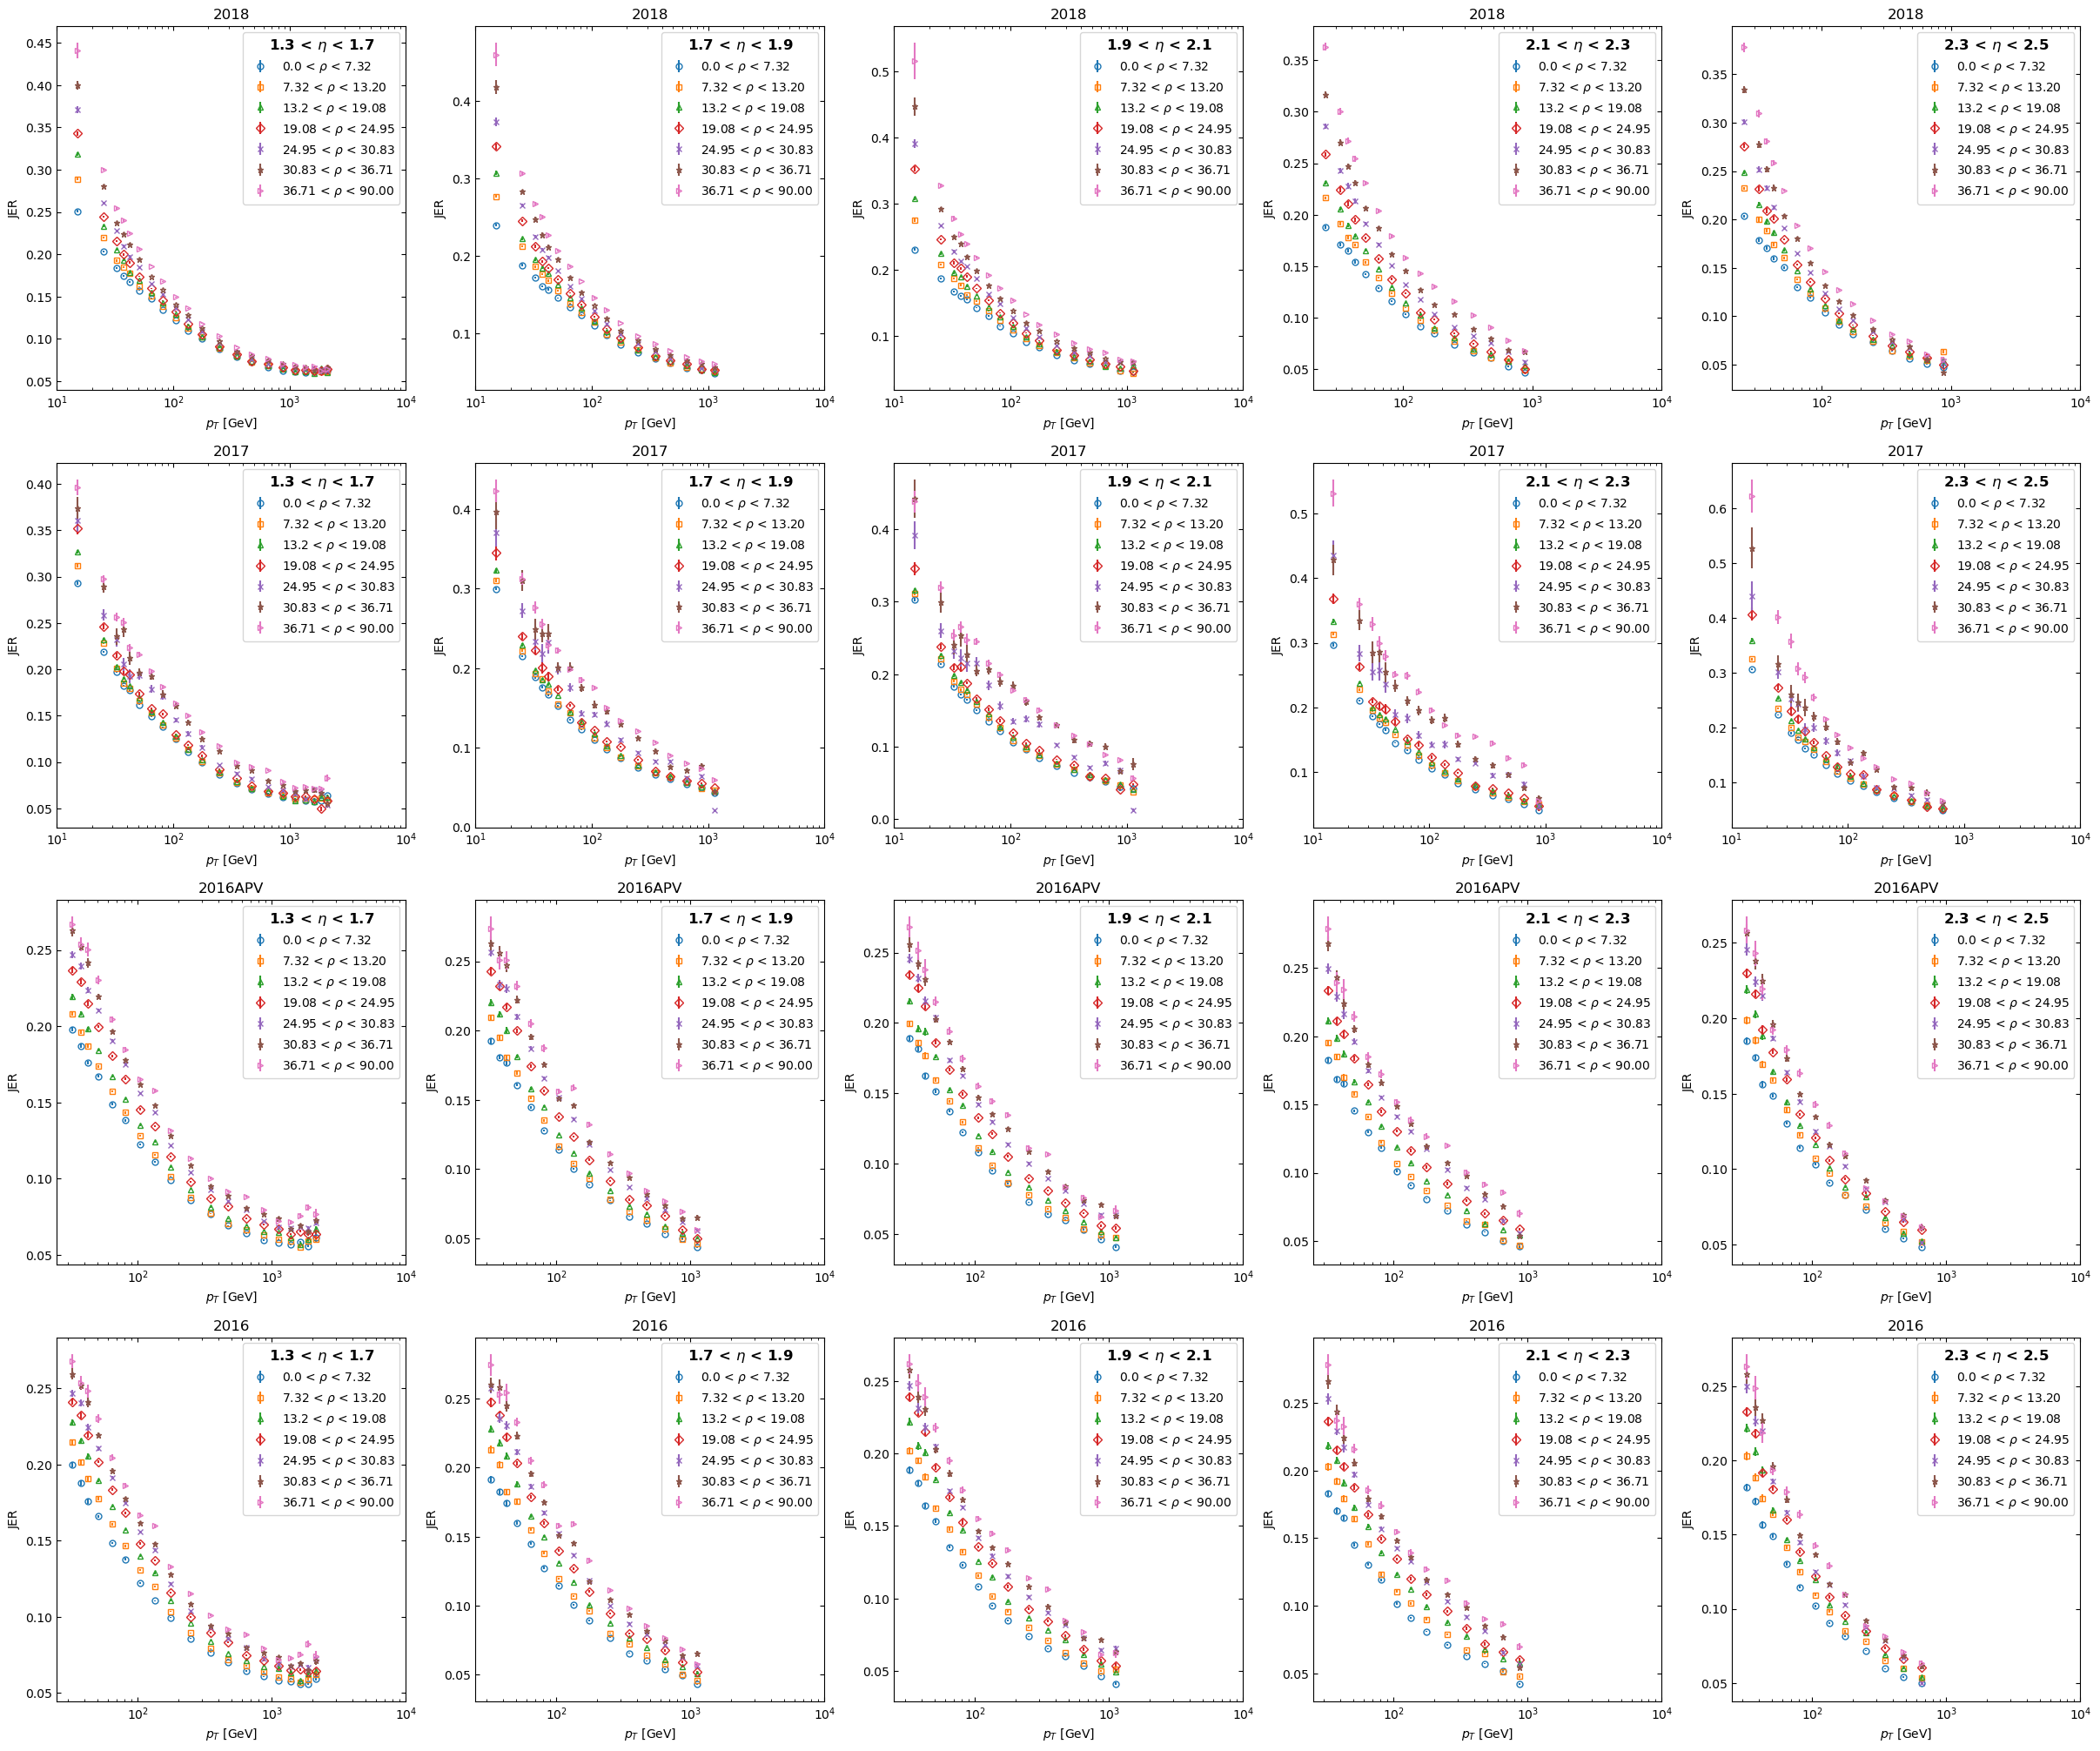

In [6]:
fig, axs = plt.subplots(4, 5, figsize=(30, 25))

markers = ['o', 's', '^', 'D', 'x', '*', '>']
marker_size = 5 

##################### 2018

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2018[0], sigma_errs_lists_2018[0], filenames_lists_2018[0])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[0, 0].errorbar(pt_bin_centers[0:21], sigmas[0:21], yerr=sigma_errs[0:21], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)   
axs[0, 0].set_title(year)
axs[0, 0].set_xlabel(r"$p_T$ [GeV]")
axs[0, 0].set_ylabel("JER")
axs[0, 0].set_xscale('log')
axs[0, 0].set_xlim(left=10)
legend = axs[0, 0].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2018[1], sigma_errs_lists_2018[1], filenames_lists_2018[1])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[0, 1].errorbar(pt_bin_centers[0:17], sigmas[0:17], yerr=sigma_errs[0:17], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[0, 1].set_title(year)
axs[0, 1].set_xlabel(r"$p_T$ [GeV]")
axs[0, 1].set_ylabel("JER")
axs[0, 1].set_xscale('log')
axs[0, 1].set_xlim(left=10)
legend = axs[0, 1].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2018[2], sigma_errs_lists_2018[2], filenames_lists_2018[2])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[0, 2].errorbar(pt_bin_centers[0:17], sigmas[0:17], yerr=sigma_errs[0:17], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[0, 2].set_title(year)
axs[0, 2].set_xlabel(r"$p_T$ [GeV]")
axs[0, 2].set_ylabel("JER")
axs[0, 2].set_xscale('log')
axs[0, 2].set_xlim(left=10)
legend = axs[0, 2].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')   

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2018[3], sigma_errs_lists_2018[3], filenames_lists_2018[3])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[0, 3].errorbar(pt_bin_centers[1:16], sigmas[1:16], yerr=sigma_errs[1:16], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[0, 3].set_title(year)
axs[0, 3].set_xlabel(r"$p_T$ [GeV]")
axs[0, 3].set_ylabel("JER")
axs[0, 3].set_xscale('log')
axs[0, 3].set_xlim(left=20)
legend = axs[0, 3].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2018[4], sigma_errs_lists_2018[4], filenames_lists_2018[4])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[0, 4].errorbar(pt_bin_centers[1:16], sigmas[1:16], yerr=sigma_errs[1:16], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[0, 4].set_title(year)
axs[0, 4].set_xlabel(r"$p_T$ [GeV]")
axs[0, 4].set_ylabel("JER")
axs[0, 4].set_xscale('log')
axs[0, 4].set_xlim(left=20)
legend = axs[0, 4].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 

##################### 2017
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2017[0], sigma_errs_lists_2017[0], filenames_lists_2017[0])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[1, 0].errorbar(pt_bin_centers[0:21], sigmas[0:21], yerr=sigma_errs[0:21], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[1, 0].set_title(year)
axs[1, 0].set_xlabel(r"$p_T$ [GeV]")
axs[1, 0].set_ylabel("JER")
axs[1, 0].set_xscale('log')
axs[1, 0].set_xlim(left=10)
legend = axs[1, 0].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2017[1], sigma_errs_lists_2017[1], filenames_lists_2017[1])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[1, 1].errorbar(pt_bin_centers[0:17], sigmas[0:17], yerr=sigma_errs[0:17], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[1, 1].set_title(year)
axs[1, 1].set_xlabel(r"$p_T$ [GeV]")
axs[1, 1].set_ylabel("JER")
axs[1, 1].set_xscale('log')
axs[1, 1].set_xlim(left=10)
legend = axs[1, 1].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2017[2], sigma_errs_lists_2017[2], filenames_lists_2017[2])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[1, 2].errorbar(pt_bin_centers[0:17], sigmas[0:17], yerr=sigma_errs[0:17], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[1, 2].set_title(year)
axs[1, 2].set_xlabel(r"$p_T$ [GeV]")
axs[1, 2].set_ylabel("JER")
axs[1, 2].set_xscale('log')
axs[1, 2].set_xlim(left=10)
legend = axs[1, 2].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2017[3], sigma_errs_lists_2017[3], filenames_lists_2017[3])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[1, 3].errorbar(pt_bin_centers[0:16], sigmas[0:16], yerr=sigma_errs[0:16], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[1, 3].set_title(year)
axs[1, 3].set_xlabel(r"$p_T$ [GeV]")
axs[1, 3].set_ylabel("JER")
axs[1, 3].set_xscale('log')
axs[1, 3].set_xlim(left=10)
legend = axs[1, 3].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2017[4], sigma_errs_lists_2017[4], filenames_lists_2017[4])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[1, 4].errorbar(pt_bin_centers[0:15], sigmas[0:15], yerr=sigma_errs[0:15], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[1, 4].set_title(year)
axs[1, 4].set_xlabel(r"$p_T$ [GeV]")
axs[1, 4].set_ylabel("JER")
axs[1, 4].set_xscale('log')
axs[1, 4].set_xlim(left=10)
legend = axs[1, 4].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 
    
##################### 2016APV

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016APV[0], sigma_errs_lists_2016APV[0], filenames_lists_2016APV[0])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[2, 0].errorbar(pt_bin_centers[2:21], sigmas[2:21], yerr=sigma_errs[2:21], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[2, 0].set_title(year)
axs[2, 0].set_xlabel(r"$p_T$ [GeV]")
axs[2, 0].set_ylabel("JER")
axs[2, 0].set_xscale('log')
axs[2, 0].set_xlim(left=25)
legend = axs[2, 0].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016APV[1], sigma_errs_lists_2016APV[1], filenames_lists_2016APV[1])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[2, 1].errorbar(pt_bin_centers[2:17], sigmas[2:17], yerr=sigma_errs[2:17], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[2, 1].set_title(year)
axs[2, 1].set_xlabel(r"$p_T$ [GeV]")
axs[2, 1].set_ylabel("JER")
axs[2, 1].set_xscale('log')
axs[2, 1].set_xlim(left=25)
legend = axs[2, 1].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016APV[2], sigma_errs_lists_2016APV[2], filenames_lists_2016APV[2])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[2, 2].errorbar(pt_bin_centers[2:17], sigmas[2:17], yerr=sigma_errs[2:17], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[2, 2].set_title(year)
axs[2, 2].set_xlabel(r"$p_T$ [GeV]")
axs[2, 2].set_ylabel("JER")
axs[2, 2].set_xscale('log')
axs[2, 2].set_xlim(left=25)
legend = axs[2, 2].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')    

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016APV[3], sigma_errs_lists_2016APV[3], filenames_lists_2016APV[3])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[2, 3].errorbar(pt_bin_centers[2:16], sigmas[2:16], yerr=sigma_errs[2:16], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[2, 3].set_title(year)
axs[2, 3].set_xlabel(r"$p_T$ [GeV]")
axs[2, 3].set_ylabel("JER")
axs[2, 3].set_xscale('log')
axs[2, 3].set_xlim(left=25)
legend = axs[2, 3].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016APV[4], sigma_errs_lists_2016APV[4], filenames_lists_2016APV[4])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[2, 4].errorbar(pt_bin_centers[2:15], sigmas[2:15], yerr=sigma_errs[2:15], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[2, 4].set_title(year)
axs[2, 4].set_xlabel(r"$p_T$ [GeV]")
axs[2, 4].set_ylabel("JER")
axs[2, 4].set_xscale('log')
axs[2, 4].set_xlim(left=25)
legend = axs[2, 4].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 
    
##################### 2016

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016[0], sigma_errs_lists_2016[0], filenames_lists_2016[0])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[3, 0].errorbar(pt_bin_centers[2:21], sigmas[2:21], yerr=sigma_errs[2:21], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[3, 0].set_title(year)
axs[3, 0].set_xlabel(r"$p_T$ [GeV]")
axs[3, 0].set_ylabel("JER")
axs[3, 0].set_xscale('log')
axs[3, 0].set_xlim(left=25)
legend = axs[3, 0].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016[1], sigma_errs_lists_2016[1], filenames_lists_2016[1])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[3, 1].errorbar(pt_bin_centers[2:17], sigmas[2:17], yerr=sigma_errs[2:17], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[3, 1].set_title(year)
axs[3, 1].set_xlabel(r"$p_T$ [GeV]")
axs[3, 1].set_ylabel("JER")
axs[3, 1].set_xscale('log')
axs[3, 1].set_xlim(left=25)
legend = axs[3, 1].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016[2], sigma_errs_lists_2016[2], filenames_lists_2016[2])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[3, 2].errorbar(pt_bin_centers[2:17], sigmas[2:17], yerr=sigma_errs[2:17], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[3, 2].set_title(year)
axs[3, 2].set_xlabel(r"$p_T$ [GeV]")
axs[3, 2].set_ylabel("JER")
axs[3, 2].set_xscale('log')
axs[3, 2].set_xlim(left=25)
legend = axs[3, 2].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')    

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016[3], sigma_errs_lists_2016[3], filenames_lists_2016[3])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[3, 3].errorbar(pt_bin_centers[2:16], sigmas[2:16], yerr=sigma_errs[2:16], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[3, 3].set_title(year)
axs[3, 3].set_xlabel(r"$p_T$ [GeV]")
axs[3, 3].set_ylabel("JER")
axs[3, 3].set_xscale('log')
axs[3, 3].set_xlim(left=25)
legend = axs[3, 3].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold') 
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016[4], sigma_errs_lists_2016[4], filenames_lists_2016[4])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[3, 4].errorbar(pt_bin_centers[2:15], sigmas[2:15], yerr=sigma_errs[2:15], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[3, 4].set_title(year)
axs[3, 4].set_xlabel(r"$p_T$ [GeV]")
axs[3, 4].set_ylabel("JER")
axs[3, 4].set_xscale('log')
axs[3, 4].set_xlim(left=25)
legend = axs[3, 4].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  

for ax in axs.flatten():
    ax.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)
    ax.set_xlim(right=10000)
plt.show()

### Forward measurements

Finally, we perform the same analysis for the forward $2.5 < \eta < 4.7$ part of the detector:

In [7]:
eta_ranges = [(2.5, 2.8), (2.8, 3.0), (3.0, 3.2), (3.2, 4.7)]

rho_ranges = [(0., 7.32), (7.32, 13.2), (13.2, 19.08), (19.08, 24.95), (24.95, 30.83), (30.83, 36.71), (36.71, 90)]

##################### 2018

era_2018 = 2018

pt_bin_lists_2018 = []
sigmas_lists_2018 = []
sigma_errs_lists_2018 = []
filenames_lists_2018 = []
dfs_lists_2018 = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2018, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2018.append(pt_bins)
    sigmas_lists_2018.append(sigmas)
    sigma_errs_lists_2018.append(sigma_errs)
    filenames_lists_2018.append(filenames)
    dfs_lists_2018.append(dfs)
    
##################### 2017

era_2017 = 2017

pt_bin_lists_2017 = []
sigmas_lists_2017 = []
sigma_errs_lists_2017 = []
filenames_lists_2017 = []
dfs_lists_2017 = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2017, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2017.append(pt_bins)
    sigmas_lists_2017.append(sigmas)
    sigma_errs_lists_2017.append(sigma_errs)
    filenames_lists_2017.append(filenames)
    dfs_lists_2017.append(dfs)

##################### 2016APV

era_2016APV = '2016APV'

pt_bin_lists_2016APV = []
sigmas_lists_2016APV = []
sigma_errs_lists_2016APV = []
filenames_lists_2016APV = []
dfs_lists_2016APV = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2016APV, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2016APV.append(pt_bins)
    sigmas_lists_2016APV.append(sigmas)
    sigma_errs_lists_2016APV.append(sigma_errs)
    filenames_lists_2016APV.append(filenames)
    dfs_lists_2016APV.append(dfs)

##################### 2016

era_2016 = 2016

pt_bin_lists_2016 = []
sigmas_lists_2016 = []
sigma_errs_lists_2016 = []
filenames_lists_2016 = []
dfs_lists_2016 = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2016, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2016.append(pt_bins)
    sigmas_lists_2016.append(sigmas)
    sigma_errs_lists_2016.append(sigma_errs)
    filenames_lists_2016.append(filenames)
    dfs_lists_2016.append(dfs)

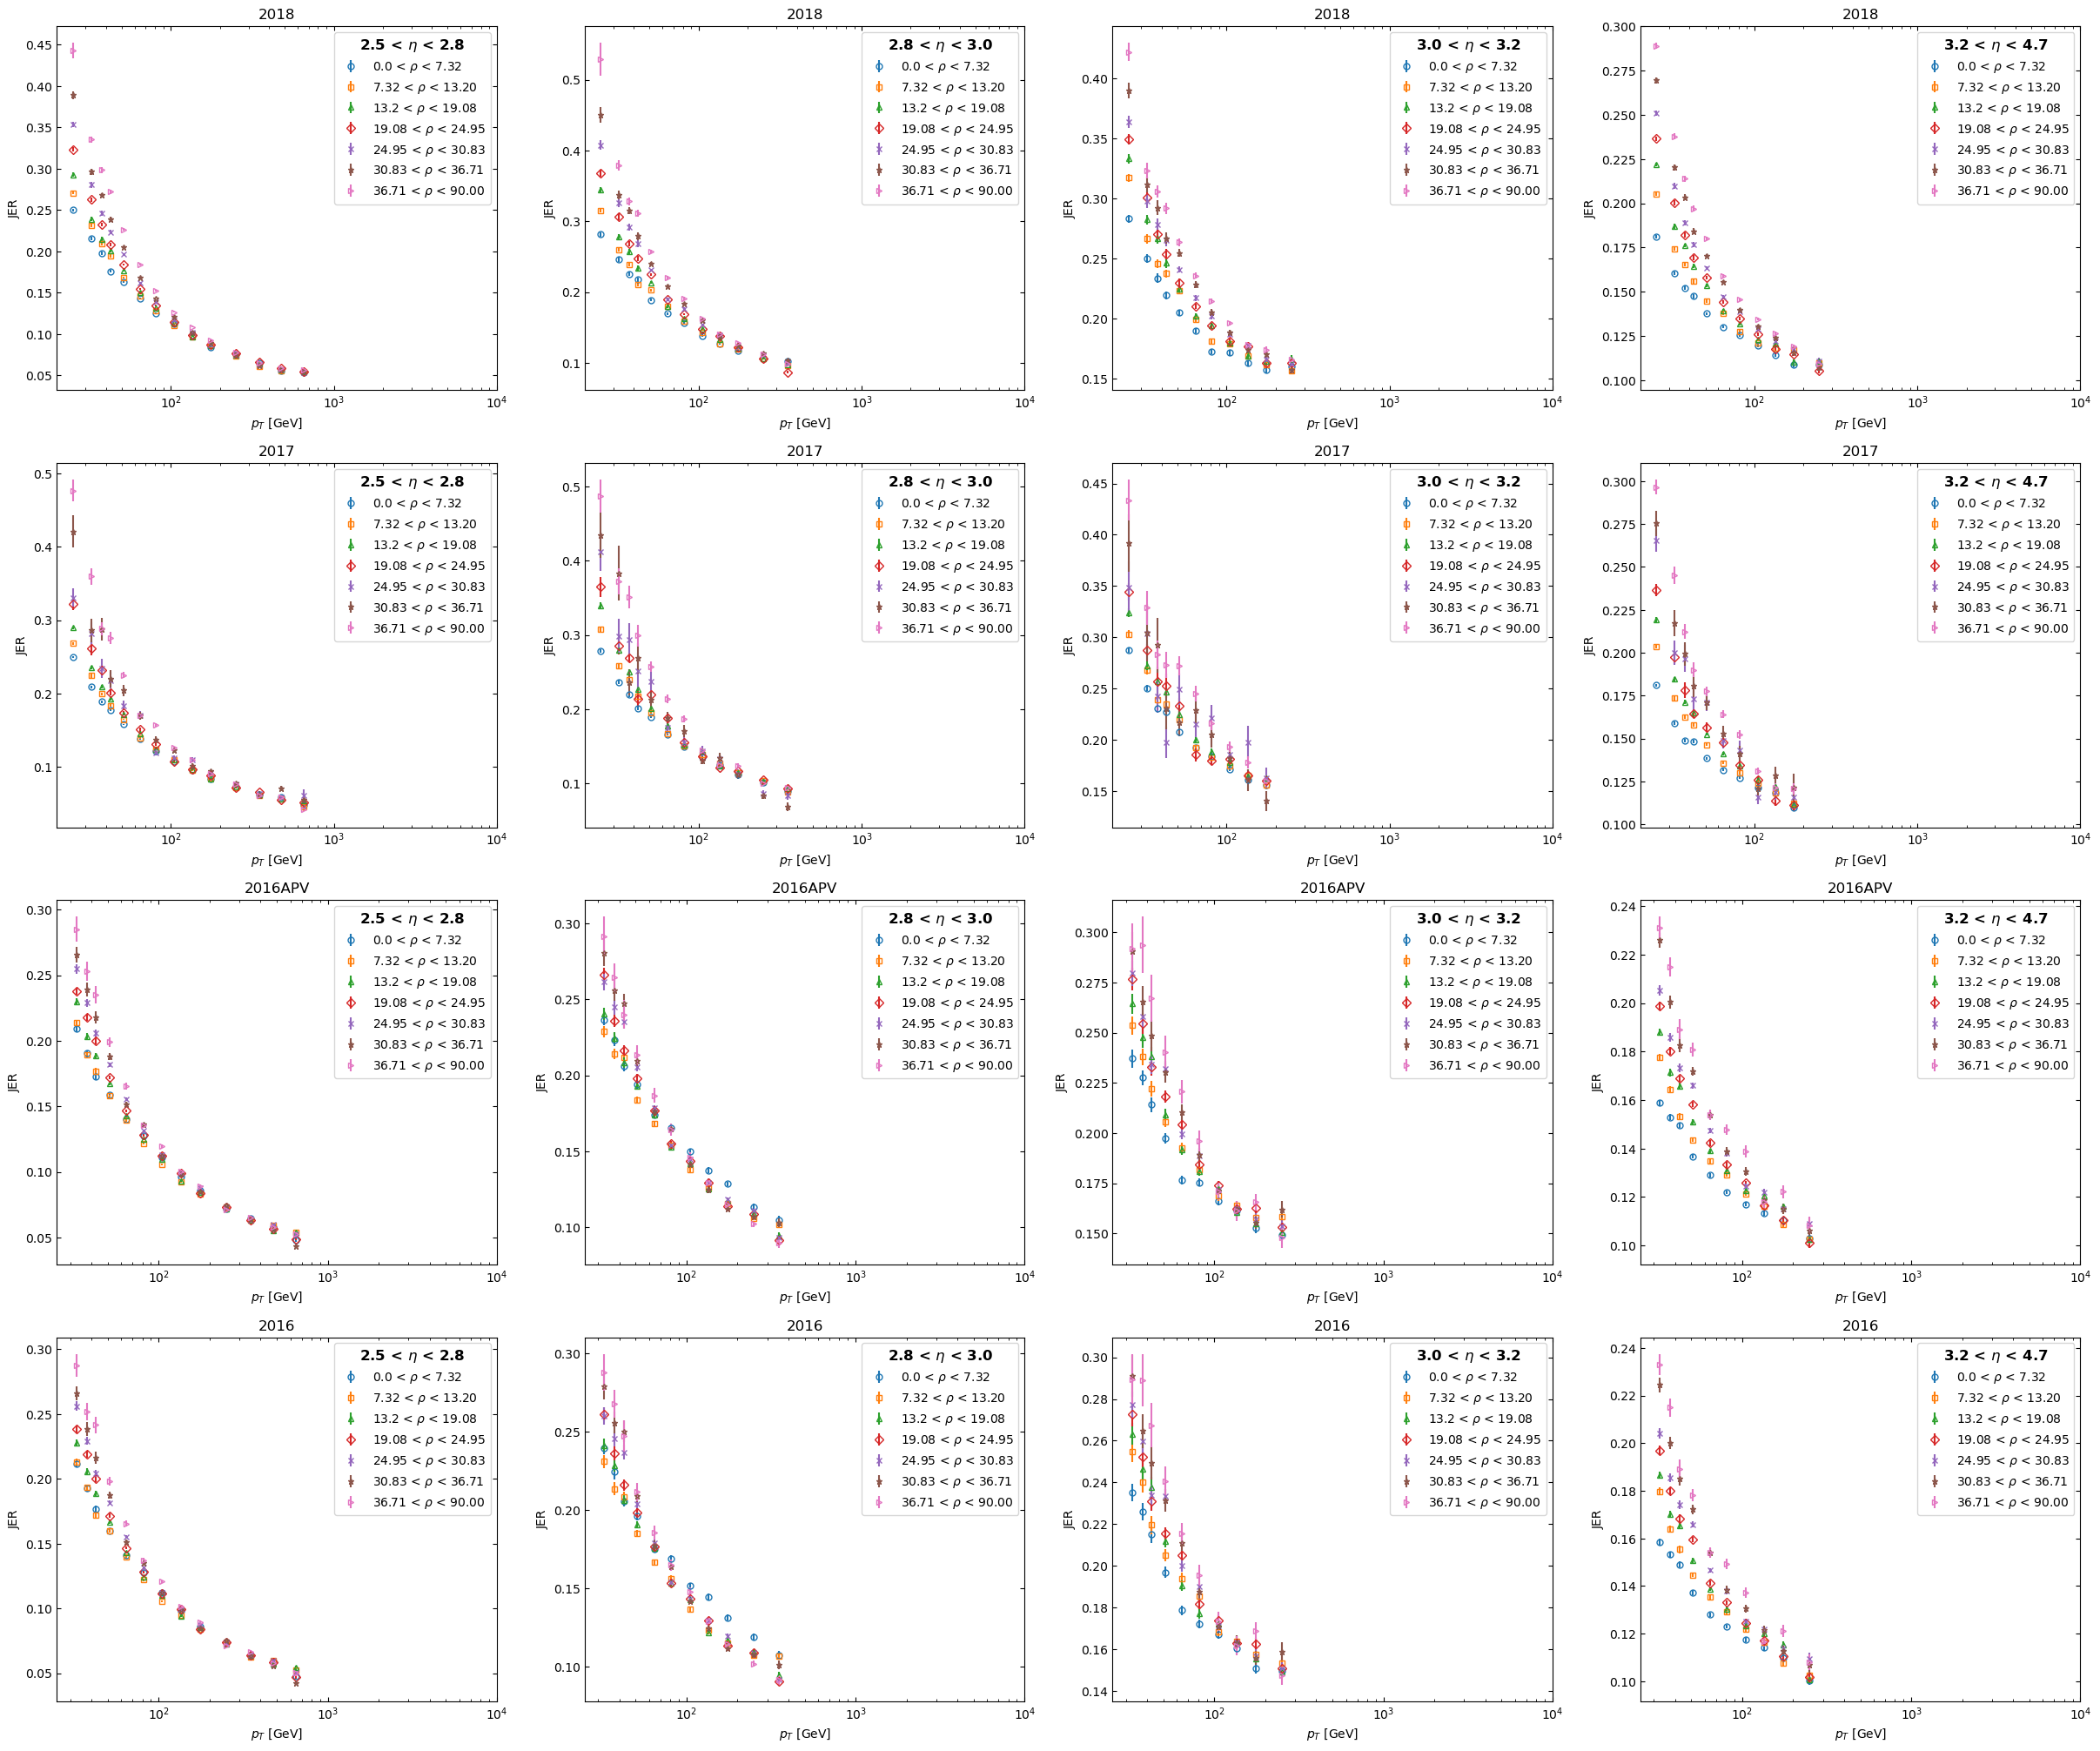

In [8]:
fig, axs = plt.subplots(4, 4, figsize=(30, 25))

markers = ['o', 's', '^', 'D', 'x', '*', '>']
marker_size = 5 

##################### 2018

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2018[0], sigma_errs_lists_2018[0], filenames_lists_2018[0])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[0, 0].errorbar(pt_bin_centers[1:15], sigmas[1:15], yerr=sigma_errs[1:15], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)     # Use label=filename to verify file
axs[0, 0].set_title(year)
axs[0, 0].set_xlabel(r"$p_T$ [GeV]")
axs[0, 0].set_ylabel("JER")
axs[0, 0].set_xscale('log')
axs[0, 0].set_xlim(left=20)
legend = axs[0, 0].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2018[1], sigma_errs_lists_2018[1], filenames_lists_2018[1])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[0, 1].errorbar(pt_bin_centers[1:13], sigmas[1:13], yerr=sigma_errs[1:13], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[0, 1].set_title(year)
axs[0, 1].set_xlabel(r"$p_T$ [GeV]")
axs[0, 1].set_ylabel("JER")
axs[0, 1].set_xscale('log')
axs[0, 1].set_xlim(left=20)
legend = axs[0, 1].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2018[2], sigma_errs_lists_2018[2], filenames_lists_2018[2])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[0, 2].errorbar(pt_bin_centers[1:12], sigmas[1:12], yerr=sigma_errs[1:12], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[0, 2].set_title(year)
axs[0, 2].set_xlabel(r"$p_T$ [GeV]")
axs[0, 2].set_ylabel("JER")
axs[0, 2].set_xscale('log')
axs[0, 2].set_xlim(left=20)  
legend = axs[0, 2].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')                                  

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2018[3], sigma_errs_lists_2018[3], filenames_lists_2018[3])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[0, 3].errorbar(pt_bin_centers[1:12], sigmas[1:12], yerr=sigma_errs[1:12], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[0, 3].set_title(year)
axs[0, 3].set_xlabel(r"$p_T$ [GeV]")
axs[0, 3].set_ylabel("JER")
axs[0, 3].set_xscale('log')
axs[0, 3].set_xlim(left=20)
legend = axs[0, 3].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')                                  

##################### 2017
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2017[0], sigma_errs_lists_2017[0], filenames_lists_2017[0])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[1, 0].errorbar(pt_bin_centers[1:15], sigmas[1:15], yerr=sigma_errs[1:15], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[1, 0].set_title(year)
axs[1, 0].set_xlabel(r"$p_T$ [GeV]")
axs[1, 0].set_ylabel("JER")
axs[1, 0].set_xscale('log')
axs[1, 0].set_xlim(left=20)
legend = axs[1, 0].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')                                  

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2017[1], sigma_errs_lists_2017[1], filenames_lists_2017[1])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[1, 1].errorbar(pt_bin_centers[1:13], sigmas[1:13], yerr=sigma_errs[1:13], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[1, 1].set_title(year)
axs[1, 1].set_xlabel(r"$p_T$ [GeV]")
axs[1, 1].set_ylabel("JER")
axs[1, 1].set_xscale('log')
axs[1, 1].set_xlim(left=20)
legend = axs[1, 1].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')                                  
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2017[2], sigma_errs_lists_2017[2], filenames_lists_2017[2])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[1, 2].errorbar(pt_bin_centers[1:11], sigmas[1:11], yerr=sigma_errs[1:11], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[1, 2].set_title(year)
axs[1, 2].set_xlabel(r"$p_T$ [GeV]")
axs[1, 2].set_ylabel("JER")
axs[1, 2].set_xscale('log')
axs[1, 2].set_xlim(left=20)  
legend = axs[1, 2].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')                                  

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2017[3], sigma_errs_lists_2017[3], filenames_lists_2017[3])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[1, 3].errorbar(pt_bin_centers[1:11], sigmas[1:11], yerr=sigma_errs[1:11], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[1, 3].set_title(year)
axs[1, 3].set_xlabel(r"$p_T$ [GeV]")
axs[1, 3].set_ylabel("JER")
axs[1, 3].set_xscale('log')
axs[1, 3].set_xlim(left=20)
legend = axs[1, 3].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  
    
##################### 2016APV

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016APV[0], sigma_errs_lists_2016APV[0], filenames_lists_2016APV[0])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[2, 0].errorbar(pt_bin_centers[2:15], sigmas[2:15], yerr=sigma_errs[2:15], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[2, 0].set_title(year)
axs[2, 0].set_xlabel(r"$p_T$ [GeV]")
axs[2, 0].set_ylabel("JER")
axs[2, 0].set_xscale('log')
axs[2, 0].set_xlim(left=25)
legend = axs[2, 0].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016APV[1], sigma_errs_lists_2016APV[1], filenames_lists_2016APV[1])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[2, 1].errorbar(pt_bin_centers[2:13], sigmas[2:13], yerr=sigma_errs[2:13], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[2, 1].set_title(year)
axs[2, 1].set_xlabel(r"$p_T$ [GeV]")
axs[2, 1].set_ylabel("JER")
axs[2, 1].set_xscale('log')
axs[2, 1].set_xlim(left=25)
legend = axs[2, 1].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016APV[2], sigma_errs_lists_2016APV[2], filenames_lists_2016APV[2])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[2, 2].errorbar(pt_bin_centers[2:12], sigmas[2:12], yerr=sigma_errs[2:12], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[2, 2].set_title(year)
axs[2, 2].set_xlabel(r"$p_T$ [GeV]")
axs[2, 2].set_ylabel("JER")
axs[2, 2].set_xscale('log')
axs[2, 2].set_xlim(left=25)
legend = axs[2, 2].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016APV[3], sigma_errs_lists_2016APV[3], filenames_lists_2016APV[3])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[2, 3].errorbar(pt_bin_centers[2:12], sigmas[2:12], yerr=sigma_errs[2:12], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[2, 3].set_title(year)
axs[2, 3].set_xlabel(r"$p_T$ [GeV]")
axs[2, 3].set_ylabel("JER")
axs[2, 3].set_xscale('log')
axs[2, 3].set_xlim(left=25)
legend = axs[2, 3].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  
    
##################### 2016

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016[0], sigma_errs_lists_2016[0], filenames_lists_2016[0])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[3, 0].errorbar(pt_bin_centers[2:15], sigmas[2:15], yerr=sigma_errs[2:15], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[3, 0].set_title(year)
axs[3, 0].set_xlabel(r"$p_T$ [GeV]")
axs[3, 0].set_ylabel("JER")
axs[3, 0].set_xscale('log')
axs[3, 0].set_xlim(left=25)
legend = axs[3, 0].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016[1], sigma_errs_lists_2016[1], filenames_lists_2016[1])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[3, 1].errorbar(pt_bin_centers[2:13], sigmas[2:13], yerr=sigma_errs[2:13], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[3, 1].set_title(year)
axs[3, 1].set_xlabel(r"$p_T$ [GeV]")
axs[3, 1].set_ylabel("JER")
axs[3, 1].set_xscale('log')
axs[3, 1].set_xlim(left=25)
legend = axs[3, 1].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  
    
for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016[2], sigma_errs_lists_2016[2], filenames_lists_2016[2])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[3, 2].errorbar(pt_bin_centers[2:12], sigmas[2:12], yerr=sigma_errs[2:12], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[3, 2].set_title(year)
axs[3, 2].set_xlabel(r"$p_T$ [GeV]")
axs[3, 2].set_ylabel("JER")
axs[3, 2].set_xscale('log')
axs[3, 2].set_xlim(left=25)
legend = axs[3, 2].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  

for i, (sigmas, sigma_errs, filename) in enumerate(zip(sigmas_lists_2016[3], sigma_errs_lists_2016[3], filenames_lists_2016[3])):
    year = f"{filename.split('_')[filename.split('_').index('parameters') + 1]}"
    eta_labels = f"{filename.split('_')[filename.split('_').index('eta') + 1].split('-')[0]} < $\eta$ < {filename.split('_')[filename.split('_').index('eta') + 1].split('-')[1]}"
    rho_labels = f"{filename.split('_')[filename.split('_').index('rho') + 1].split('-')[0]} < $\u03c1$ < {float(filename.split('_')[filename.split('_').index('rho') + 1].split('-')[1].replace('.csv', '')):.2f}"
    marker = markers[i % len(markers)]
    axs[3, 3].errorbar(pt_bin_centers[2:12], sigmas[2:12], yerr=sigma_errs[2:12], fmt=marker, markersize=marker_size, markerfacecolor='none', label=rho_labels)
axs[3, 3].set_title(year)
axs[3, 3].set_xlabel(r"$p_T$ [GeV]")
axs[3, 3].set_ylabel("JER")
axs[3, 3].set_xscale('log')
axs[3, 3].set_xlim(left=25)
legend = axs[3, 3].legend(title=eta_labels, title_fontsize='12')
legend.get_title().set_fontweight('bold')  

for ax in axs.flatten():
    ax.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)
    ax.set_xlim(right=10000)
plt.show()

Lastly, we reproduce the barrel region plots with the use of a `plot_unfitted_jer()` function:

In [9]:
eta_ranges = [(0.0, 0.5), (0.5, 0.8), (0.8, 1.1), (1.1, 1.3)]

rho_ranges = [(0., 7.32), (7.32, 13.2), (13.2, 19.08), (19.08, 24.95), (24.95, 30.83), (30.83, 36.71), (36.71, 90)]

##################### 2018

era_2018 = 2018

pt_bin_lists_2018 = []
sigmas_lists_2018 = []
sigma_errs_lists_2018 = []
filenames_lists_2018 = []
dfs_lists_2018 = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2018, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2018.append(pt_bins)
    sigmas_lists_2018.append(sigmas)
    sigma_errs_lists_2018.append(sigma_errs)
    filenames_lists_2018.append(filenames)
    dfs_lists_2018.append(dfs)
    
##################### 2017

era_2017 = 2017

pt_bin_lists_2017 = []
sigmas_lists_2017 = []
sigma_errs_lists_2017 = []
filenames_lists_2017 = []
dfs_lists_2017 = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2017, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2017.append(pt_bins)
    sigmas_lists_2017.append(sigmas)
    sigma_errs_lists_2017.append(sigma_errs)
    filenames_lists_2017.append(filenames)
    dfs_lists_2017.append(dfs)

##################### 2016APV

era_2016APV = '2016APV'

pt_bin_lists_2016APV = []
sigmas_lists_2016APV = []
sigma_errs_lists_2016APV = []
filenames_lists_2016APV = []
dfs_lists_2016APV = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2016APV, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2016APV.append(pt_bins)
    sigmas_lists_2016APV.append(sigmas)
    sigma_errs_lists_2016APV.append(sigma_errs)
    filenames_lists_2016APV.append(filenames)
    dfs_lists_2016APV.append(dfs)

##################### 2016

era_2016 = 2016

pt_bin_lists_2016 = []
sigmas_lists_2016 = []
sigma_errs_lists_2016 = []
filenames_lists_2016 = []
dfs_lists_2016 = []

for i, eta_range in enumerate(eta_ranges):
    reader = GaussianParametersReader(era_2016, [eta_range], rho_ranges)
    reader.read_gaussian_parameters()
    pt_bins, sigmas, sigma_errs, filenames, dfs = reader.extract_sigma_and_err()
    
    pt_bin_lists_2016.append(pt_bins)
    sigmas_lists_2016.append(sigmas)
    sigma_errs_lists_2016.append(sigma_errs)
    filenames_lists_2016.append(filenames)
    dfs_lists_2016.append(dfs)

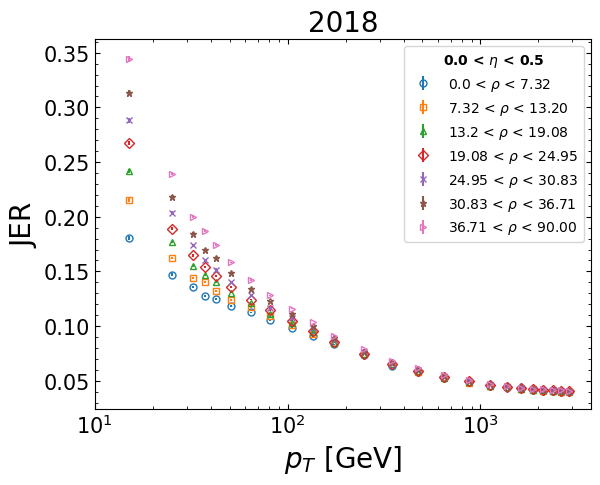

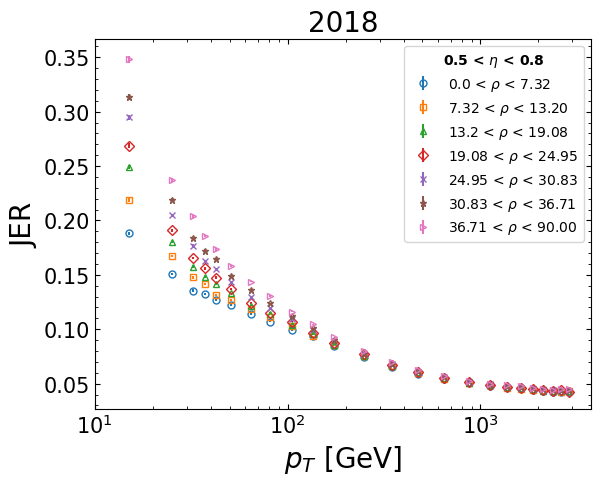

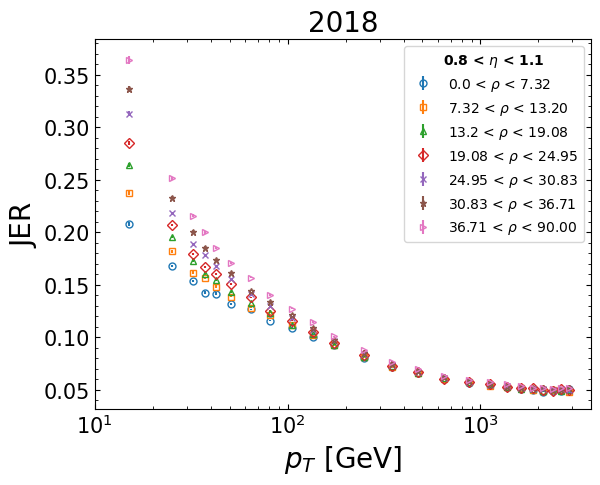

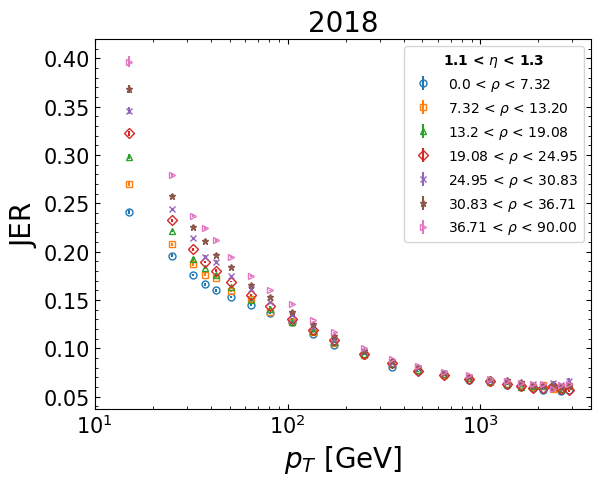

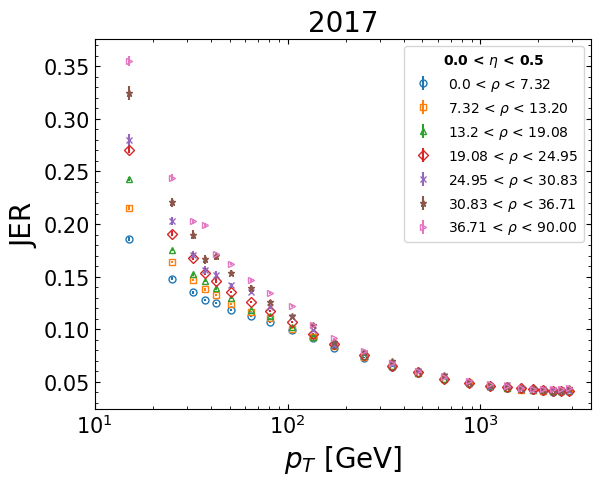

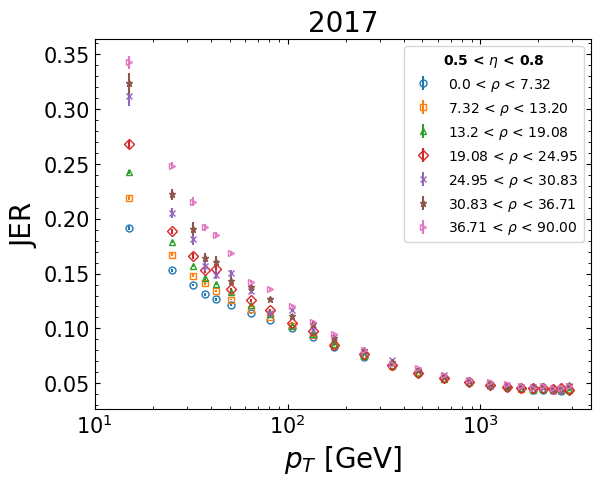

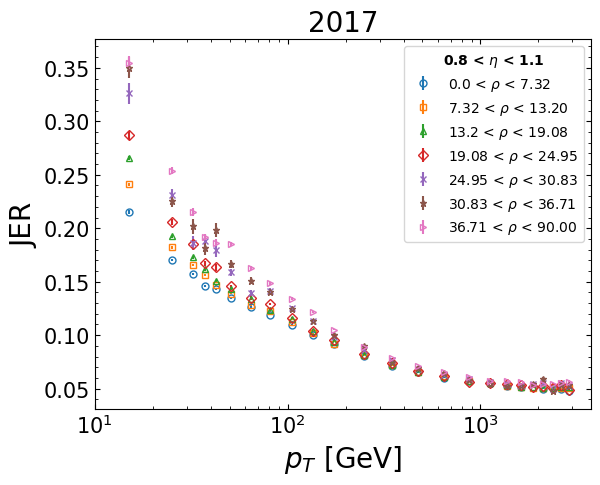

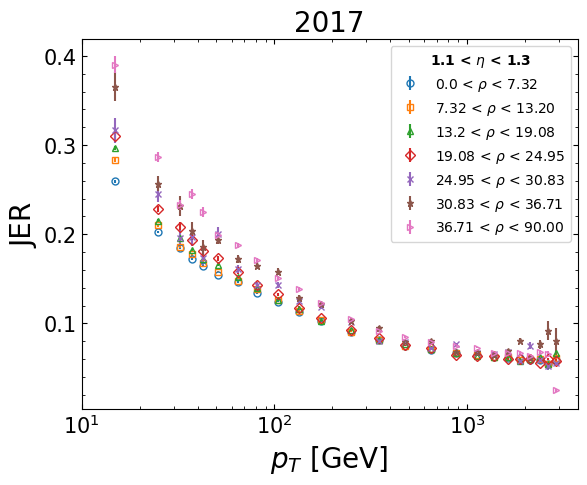

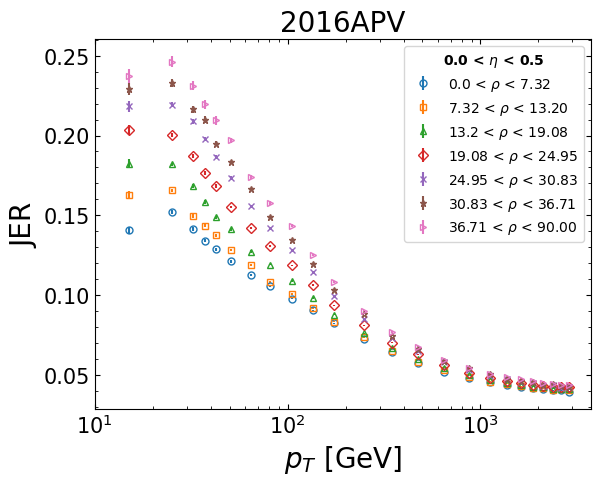

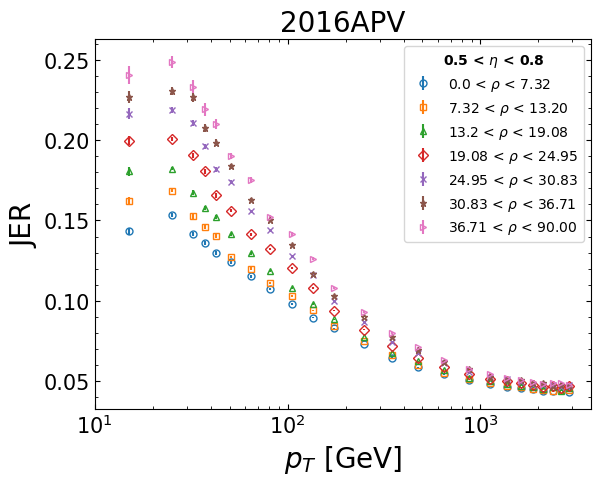

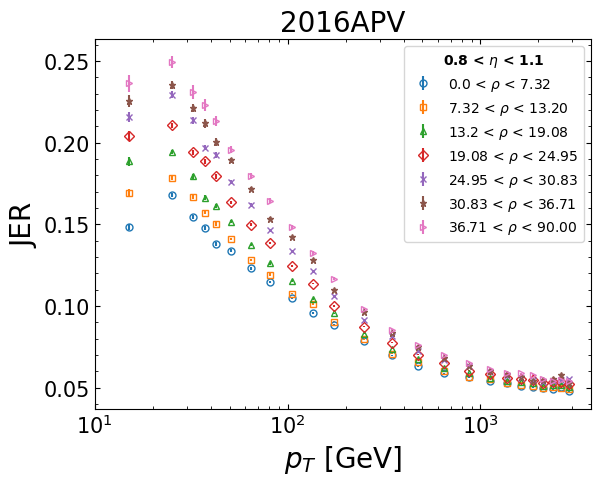

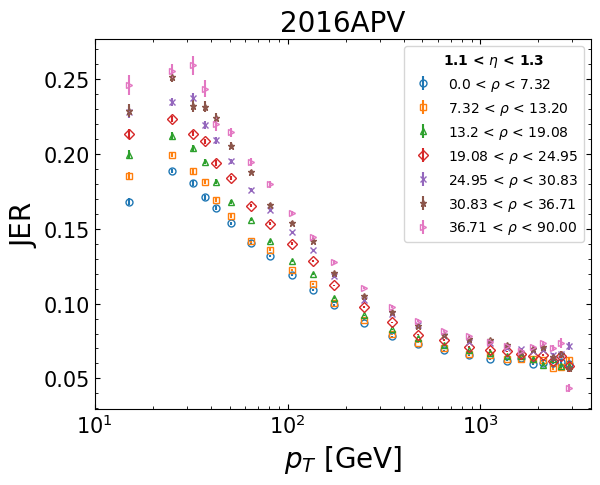

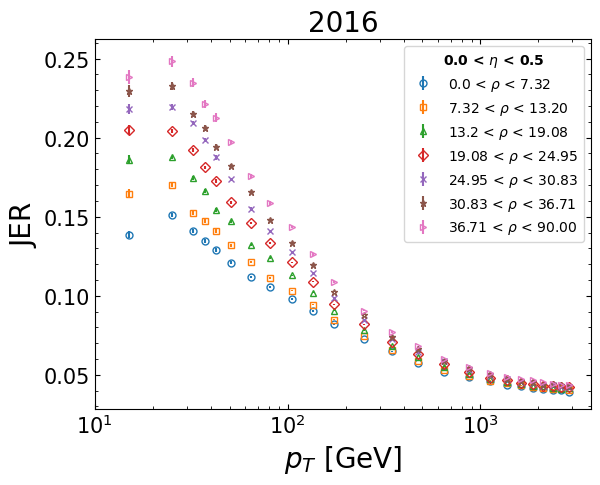

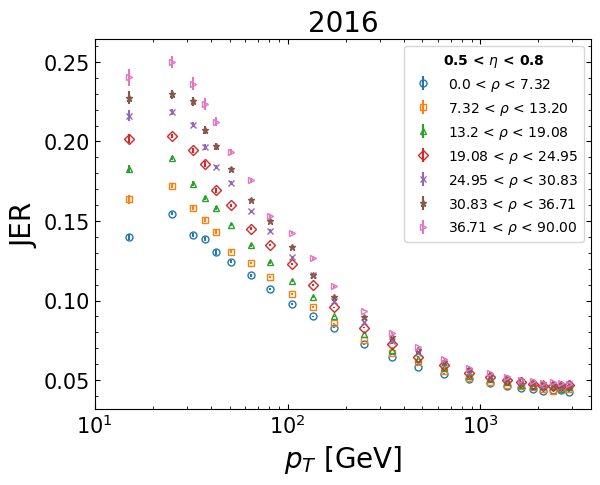

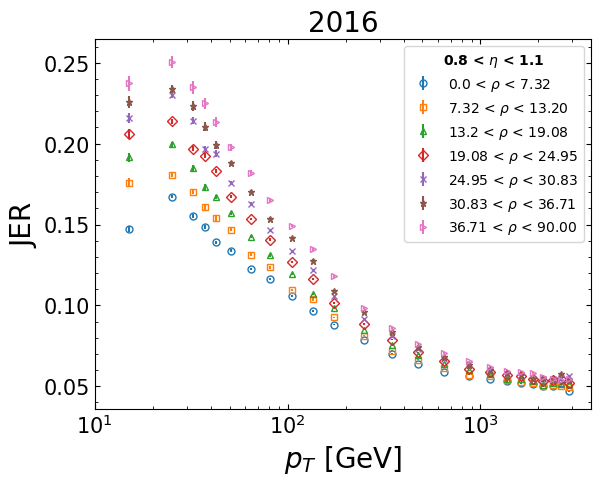

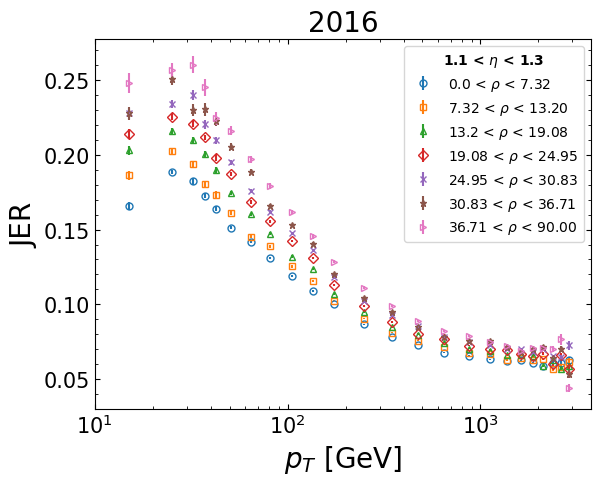

In [10]:
# 2018 Dataset

plot_unfitted_jer(sigmas_lists_2018[0], sigma_errs_lists_2018[0], filenames_lists_2018[0], pt_bin_centers, 0, 0)
plot_unfitted_jer(sigmas_lists_2018[1], sigma_errs_lists_2018[1], filenames_lists_2018[1], pt_bin_centers, 0, 1)
plot_unfitted_jer(sigmas_lists_2018[2], sigma_errs_lists_2018[2], filenames_lists_2018[2], pt_bin_centers, 0, 2)
plot_unfitted_jer(sigmas_lists_2018[3], sigma_errs_lists_2018[3], filenames_lists_2018[3], pt_bin_centers, 0, 3)

# 2017 Dataset

plot_unfitted_jer(sigmas_lists_2017[0], sigma_errs_lists_2017[0], filenames_lists_2017[0], pt_bin_centers, 1, 0)
plot_unfitted_jer(sigmas_lists_2017[1], sigma_errs_lists_2017[1], filenames_lists_2017[1], pt_bin_centers, 1, 1)
plot_unfitted_jer(sigmas_lists_2017[2], sigma_errs_lists_2017[2], filenames_lists_2017[2], pt_bin_centers, 1, 2)
plot_unfitted_jer(sigmas_lists_2017[3], sigma_errs_lists_2017[3], filenames_lists_2017[3], pt_bin_centers, 1, 3)

# 2016APV Dataset

plot_unfitted_jer(sigmas_lists_2016APV[0], sigma_errs_lists_2016APV[0], filenames_lists_2016APV[0], pt_bin_centers, 2, 0)
plot_unfitted_jer(sigmas_lists_2016APV[1], sigma_errs_lists_2016APV[1], filenames_lists_2016APV[1], pt_bin_centers, 2, 1)
plot_unfitted_jer(sigmas_lists_2016APV[2], sigma_errs_lists_2016APV[2], filenames_lists_2016APV[2], pt_bin_centers, 2, 2)
plot_unfitted_jer(sigmas_lists_2016APV[3], sigma_errs_lists_2016APV[3], filenames_lists_2016APV[3], pt_bin_centers, 2, 3)

# 2016 Dataset

plot_unfitted_jer(sigmas_lists_2016[0], sigma_errs_lists_2016[0], filenames_lists_2016[0], pt_bin_centers, 3, 0)
plot_unfitted_jer(sigmas_lists_2016[1], sigma_errs_lists_2016[1], filenames_lists_2016[1], pt_bin_centers, 3, 1)
plot_unfitted_jer(sigmas_lists_2016[2], sigma_errs_lists_2016[2], filenames_lists_2016[2], pt_bin_centers, 3, 2)
plot_unfitted_jer(sigmas_lists_2016[3], sigma_errs_lists_2016[3], filenames_lists_2016[3], pt_bin_centers, 3, 3)